In [2]:
%matplotlib inline
from IPython.display import display, Image
import pydotplus

import pandas as pd
import numpy as np
import collections
import datetime
import sklearn as sk # this isn't working for some reason... can't call below modules
from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

import matplotlib as mpl
mpl.rcParams['legend.scatterpoints'] = 1
import matplotlib.pyplot as plt

/Users/Jeff/anaconda/envs/ee-python/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
#import NLA 2007 chla
nla07chla = pd.DataFrame.from_csv('NLA/NLA2007_WaterQuality_20091123.csv')
nla07chla.reset_index(inplace=True)
nla07chla.set_index(['SITE_ID','VISIT_ID'],inplace=True)
nla07chla[['CHLA','DATECHLA']].head()
# print(nla07chla.columns.values)

# FIGURE OUT HOW TO HANDLE THE DUPLICATE VISIT_IDS (MEAN? --> would reduce data)
# other distinguishing factors besides VISIT_ID?

CHLA   DATECHLA
SITE_ID       VISIT_ID                   
NLA06608-0001 7468       0.240  7/31/2007
NLA06608-0002 7469       3.840  6/14/2007
              7470      20.053  7/23/2007
              7470      20.880  7/23/2007
NLA06608-0003 7471      16.960  8/29/2007

In [4]:
# import NLA07_L5SR data
df = pd.DataFrame.from_csv('/Users/Jeff/Google Drive/WatershedLandCover/NLA07_L5SR_getRegion.csv')
df.set_index(['SITE_ID','VISIT_ID'],inplace=True)
# display(df)
df_plus_chla = df.join(nla07chla[['CHLA','DATECHLA']])

# clean up df and add dates
df_plus_chla.dropna(subset=['CHLA'],inplace=True)
df_plus_chla.reset_index(inplace=True)
df_plus_chla['DATECHLA']= pd.to_datetime(df_plus_chla['DATECHLA'])
df_plus_chla['DATELANDSAT'] = df_plus_chla['time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000.0))
df_plus_chla['DAYS_DIFF'] = np.abs(df_plus_chla['DATECHLA'] - df_plus_chla['DATELANDSAT'])

# add log values of bands and chla
for colname in ['B1','B2','B3','B4','B5','B7','CHLA']:
    df_plus_chla['log'+colname] = np.log(df_plus_chla[colname])

# remove bad cloudmask pixels:
cfmask_dict = {0:'clear',1:'water',2:'shadow',3:'snow',4:'cloud'}
cfmask_conf_dict = {0:'none',1:'<12.5%',2:'<22.5%',3:'>22.5%'}
# https://code.earthengine.google.com/dataset/LANDSAT/LT5_SR
print(df_plus_chla['cfmask_conf'].value_counts()) #most pixels are low confidence for clouds!!
for cfm in [2,3,4]:
    df_plus_chla = df_plus_chla.loc[df_plus_chla['cfmask']!=cfm] 
    # reduces to 2271 from 3583. If n a problem later, can double check cloud confdence
print(df_plus_chla['cfmask_conf'].value_counts()) # we remove mostly higher confident clouds.
# print(df_plus_chla['cfmask'].value_counts())
# sr_land_water_qa==255 means land or water, but not always consistent
# print(df_plus_chla['sr_land_water_qa'].value_counts()) # 1558/3583...that's not a lot.
    
df_plus_chla.set_index(['SITE_ID','VISIT_ID','CHLA'],inplace=True)
display(df_plus_chla.head())
print(len(df_plus_chla))

1.0    2449
3.0    1015
2.0      42
0.0       3
Name: cfmask_conf, dtype: int64
1.0    2183
2.0      13
3.0       1
Name: cfmask_conf, dtype: int64


/Users/Jeff/anaconda/envs/ee-python/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log


B1      B2     B3      B4      B5      B7  \
SITE_ID       VISIT_ID CHLA                                                   
NLA06608-0001 7468.0   0.240   369.0   279.0  116.0   201.0     2.0    18.0   
                       0.240   439.0   315.0  151.0   246.0    79.0    93.0   
NLA06608-0002 7469.0   3.840   559.0  1089.0  769.0  3449.0  1789.0   935.0   
              7470.0   20.053  619.0  1160.0  782.0  3771.0  1973.0  1007.0   
                       20.880  619.0  1160.0  782.0  3771.0  1973.0  1007.0   

                               FID_1  cfmask  cfmask_conf                id  \
SITE_ID       VISIT_ID CHLA                                                   
NLA06608-0001 7468.0   0.240     0.0     1.0          1.0  LT50410262007213   
                       0.240     0.0     1.0          1.0  LT50420262007204   
NLA06608-0002 7469.0   3.840     2.0     0.0          1.0  LT50160372007150   
              7470.0   20.053    1.0     0.0          1.0  LT50160372007198   
                       20.880    1.0     0.0          1.0  LT50160372007198   

                                 ...      DATECHLA             DATELANDSAT  \
SITE_ID       VISIT_ID CHLA      ...                                         
NLA06608-0001 7468.0   0.240     ...    2007-07-31 2007-08-01 11:17:51.549   
                       0.240     ...    2007-07-31 2007-07-23 11:24:07.908   
NLA06608-0002 7469.0   3.840     ...    2007-06-14 2007-05-30 08:48:32.206   
              7470.0   20.053    ...    2007-07-23 2007-07-17 08:47:52.361   
                       20.880    ...    2007-07-23 2007-07-17 08:47:52.361   

                                            DAYS_DIFF     logB1     logB2  \
SITE_ID       VISIT_ID CHLA                                                 
NLA06608-0001 7468.0   0.240   1 days 11:17:51.549000  5.910797  5.631212   
                       0.240   7 days 12:35:52.092000  6.084499  5.752573   
NLA06608-0002 7469.0   3.840  14 days 15:11:27.794000  6.326149  6.993015   
              7470.0   20.053  5 days 15:12:07.639000  6.428105  7.056175   
                       20.880  5 days 15:12:07.639000  6.428105  7.056175   

                                  logB3     logB4     logB5     logB7  \
SITE_ID       VISIT_ID CHLA                                             
NLA06608-0001 7468.0   0.240   4.753590  5.303305  0.693147  2.890372   
                       0.240   5.017280  5.505332  4.369448  4.532599   
NLA06608-0002 7469.0   3.840   6.645091  8.145840  7.489412  6.840547   
              7470.0   20.053  6.661855  8.235095  7.587311  6.914731   
                       20.880  6.661855  8.235095  7.587311  6.914731   

                                logCHLA  
SITE_ID       VISIT_ID CHLA              
NLA06608-0001 7468.0   0.240  -1.427116  
                       0.240  -1.427116  
NLA06608-0002 7469.0   3.840   1.345472  
              7470.0   20.053  2.998379  
                       20.880  3.038792  

[5 rows x 26 columns]

2271


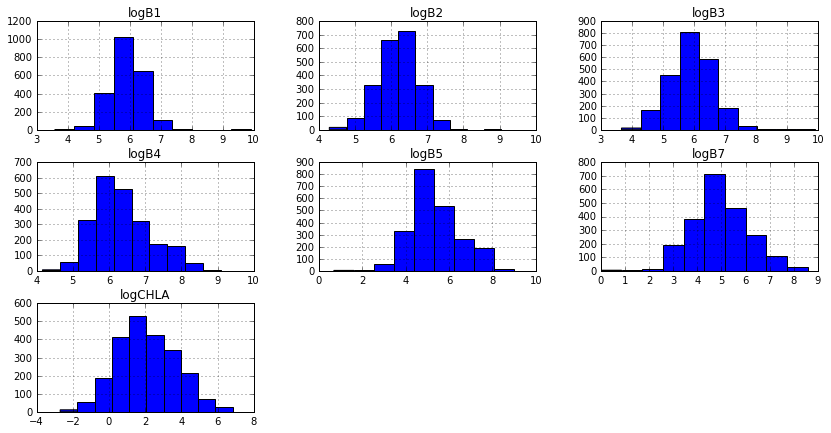

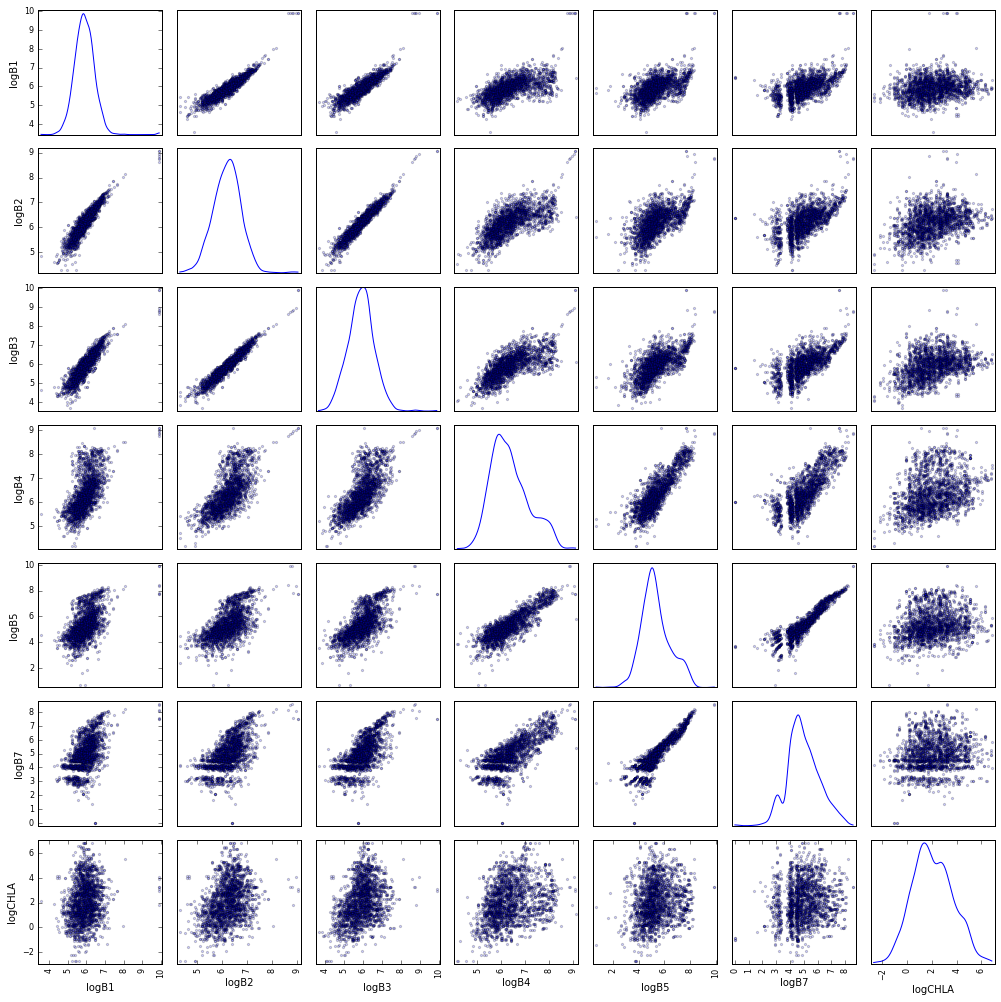

In [18]:
df_plus_chla.filter(regex='log').hist(figsize=(14,7))
plt.show()
axes = pd.tools.plotting.scatter_matrix(df_plus_chla.filter(regex='log'), figsize=(14,14), alpha=0.2, diagonal='kde')
plt.tight_layout()
plt.show()

In [5]:
# get average L5SR per each chl-a meas
grouped = df_plus_chla.groupby(level=['SITE_ID','VISIT_ID','CHLA']).mean()

# OR
# get closest L5SR per each chl-a meas
# grouped = df_plus_chla.groupby(level=['SITE_ID','VISIT_ID','CHLA']) \
#                       .apply(lambda x: x.nsmallest(1, columns=['DAYS_DIFF'])) \
#                       .reset_index(level=[3,4,5],drop=[3,4,5])
display(grouped.head(10))

B1      B2          B3           B4  \
SITE_ID       VISIT_ID CHLA                                                  
NLA06608-0001 7468.0   0.240   404.000000   297.0  133.500000   223.500000   
NLA06608-0002 7469.0   3.840   559.000000  1089.0  769.000000  3449.000000   
              7470.0   20.053  592.500000  1066.0  740.000000  3619.000000   
                       20.880  592.500000  1066.0  740.000000  3619.000000   
NLA06608-0003 7471.0   16.960  343.666667   477.0  365.666667   373.666667   
              7472.0   12.864  343.666667   477.0  365.666667   373.666667   
NLA06608-0004 7473.0   4.600   440.000000   662.0  557.000000   940.000000   
              7474.0   12.420  586.000000   840.5  785.500000  1465.000000   
                       14.720  586.000000   840.5  785.500000  1465.000000   
NLA06608-0005 7475.0   1.205   261.500000   279.5  143.500000   180.500000   

                                        B5          B7  FID_1  cfmask  \
SITE_ID       VISIT_ID CHLA                                             
NLA06608-0001 7468.0   0.240     40.500000   55.500000    0.0     1.0   
NLA06608-0002 7469.0   3.840   1789.000000  935.000000    2.0     0.0   
              7470.0   20.053  1881.000000  961.000000    1.0     0.0   
                       20.880  1881.000000  961.000000    1.0     0.0   
NLA06608-0003 7471.0   16.960   195.666667   99.666667    4.0     1.0   
              7472.0   12.864   195.666667   99.666667    3.0     1.0   
NLA06608-0004 7473.0   4.600   1016.000000  755.000000    6.0     0.0   
              7474.0   12.420  1092.000000  963.500000    5.0     0.0   
                       14.720  1092.000000  963.500000    5.0     0.0   
NLA06608-0005 7475.0   1.205    103.500000   90.000000    7.0     1.0   

                               cfmask_conf   latitude    ...     \
SITE_ID       VISIT_ID CHLA                              ...      
NLA06608-0001 7468.0   0.240           1.0  48.979159    ...      
NLA06608-0002 7469.0   3.840           1.0  33.036128    ...      
              7470.0   20.053          1.0  33.036128    ...      
                       20.880          1.0  33.036128    ...      
NLA06608-0003 7471.0   16.960          1.0  28.047784    ...      
              7472.0   12.864          1.0  28.047784    ...      
NLA06608-0004 7473.0   4.600           1.0  37.416493    ...      
              7474.0   12.420          1.0  37.416493    ...      
                       14.720          1.0  37.416493    ...      
NLA06608-0005 7475.0   1.205           1.0  43.929100    ...      

                               sr_land_water_qa           time  .geo  \
SITE_ID       VISIT_ID CHLA                                            
NLA06608-0001 7468.0   0.240              255.0  1185603659728   NaN   
NLA06608-0002 7469.0   3.840                NaN  1180540112206   NaN   
              7470.0   20.053               NaN  1185378467640   NaN   
                       20.880               NaN  1185378467640   NaN   
NLA06608-0003 7471.0   16.960             255.0  1188377688860   NaN   
              7472.0   12.864             255.0  1188377688860   NaN   
NLA06608-0004 7473.0   4.600                NaN  1183743851906   NaN   
              7474.0   12.420               NaN  1189964611641   NaN   
                       14.720               NaN  1189964611641   NaN   
NLA06608-0005 7475.0   1.205              255.0  1184998576165   NaN   

                                  logB1     logB2     logB3     logB4  \
SITE_ID       VISIT_ID CHLA                                             
NLA06608-0001 7468.0   0.240   5.997648  5.691892  4.885435  5.404318   
NLA06608-0002 7469.0   3.840   6.326149  6.993015  6.645091  8.145840   
              7470.0   20.053  6.383350  6.967766  6.605037  8.193070   
                       20.880  6.383350  6.967766  6.605037  8.193070   
NLA06608-0003 7471.0   16.960  5.838172  6.166699  5.900555  5.855019   
              7472.0   12.864  5.838172  6.1

In [29]:
#clean up for data + create chla categories
data = grouped.reset_index(level=2)
print(data['CHLA'].max())
data['CHLAcat'] = pd.cut(data['CHLA'], bins=[0, 10, 50, 1000], include_lowest=True,
                         labels=['A', 'B', 'C'])

# get columns for regression 
# data = data.filter(regex='log')
# data = data.loc[:,['B1','B2','B3','B4','B5','B7','CHLA']]
# data = data.loc[:,['B1','B2','B3','B4','B5','B7','CHLA','CHLAcat']]
data = data.loc[:,['logB1','logB2','logB3','logB4','logB5','logB7','CHLAcat']]

data.dropna(axis=0,how='any',inplace=True)
display(data.head())
# print(data.describe())
print(len(data))

# split into training and test data sets
train, test = train_test_split(data, test_size = 0.2,random_state=0
                               ,stratify=data['CHLAcat'])
print(len(train))
display(train['CHLAcat'].value_counts())
print(len(test))
display(test['CHLAcat'].value_counts())

# look at std() in each agg too relative to overall std to check for assumption of mean


936.0


logB1     logB2     logB3     logB4     logB5  \
SITE_ID       VISIT_ID                                                     
NLA06608-0001 7468.0    5.997648  5.691892  4.885435  5.404318  2.531298   
NLA06608-0002 7469.0    6.326149  6.993015  6.645091  8.145840  7.489412   
              7470.0    6.383350  6.967766  6.605037  8.193070  7.538361   
              7470.0    6.383350  6.967766  6.605037  8.193070  7.538361   
NLA06608-0003 7471.0    5.838172  6.166699  5.900555  5.855019  5.216900   

                           logB7 CHLAcat  
SITE_ID       VISIT_ID                    
NLA06608-0001 7468.0    3.711486       A  
NLA06608-0002 7469.0    6.840547       A  
              7470.0    6.866827       B  
              7470.0    6.866827       B  
NLA06608-0003 7471.0    4.410081       B

1095
876


A    478
B    260
C    138
Name: CHLAcat, dtype: int64

219


A    120
B     65
C     34
Name: CHLAcat, dtype: int64

In [30]:
# split into test and training variables
prednames = ['logB1','logB2','logB3','logB4','logB5','logB7']
ycol = 'CHLAcat'
# prednames = ['B1','B2','B3','B4','B5','B7']
# ycol = 'CHLA'
y = np.array(train[ycol])
X = np.array(train[prednames])
y_test = np.array(test[ycol])
X_test = np.array(test[prednames])

In [11]:
# linear regression
# fit model
lr = linear_model.LinearRegression()
lr.fit(X, y)
r2_train = lr.score(X,y)
r2_test = lr.score(X_test,y_test)
mse_test = np.sqrt( np.mean((lr.predict(X_test) - y_test) ** 2) )

print('Coefficients:')
print('Intercept: {}'.format(lr.intercept_))
print(zip(prednames,lr.coef_))
print("Root mean squared test error: %.2f %s" %(mse_test,ycol))
print('R2 test score: %.5f' % r2_test)
print('R2 training score: %.5f' % r2_train)

#sklearn has these crappy wrappers for outputs of models. 
# Can't even output the model??Try statsmodels!

ValueError: could not convert string to float: A

In [45]:
# linear regression using statsmodels instead of sklearn
# fit model
Xsm = sm.add_constant(X)
# print(Xsm)
lr2 = sm.OLS(y,Xsm).fit()

print('Coefficients:')
print('Intercept: {}'.format(lr2.params[0]))
print(zip(prednames,lr2.params[1:]))
print(lr2.summary())

#sklearn has these crappy wrappers for outputs of models. 
# Can't even output the model??Try statsmodels!

Coefficients:
Intercept: -2.42581663437
[('logB1', -3.0845151804161444), ('logB2', 1.3693222155016425), ('logB3', 2.2244857734147714), ('logB4', 0.81784428673619336), ('logB5', -0.51787155316259903), ('logB7', -0.25292368909446078)]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     74.97
Date:                Thu, 08 Jun 2017   Prob (F-statistic):           2.13e-75
Time:                        14:25:26   Log-Likelihood:                -1464.7
No. Observations:                 876   AIC:                             2943.
Df Residuals:                     869   BIC:                             2977.
Df Model:                           6                                         
Covariance Type:            nonrobust                   

In [46]:
# lasso
# fit model
las = linear_model.Lasso(alpha=0.04) #alpha>0.4: all coefs 0
las.fit(X, y)
r2_train = las.score(X,y)
r2_test = las.score(X_test,y_test)
mse_test = np.sqrt( np.mean((las.predict(X_test) - y_test) ** 2) )

print('Coefficients:')
print('Intercept: {}'.format(las.intercept_))
print(zip(prednames,las.coef_))
print("Root mean squared test error: %.2f logCHLA" % mse_test)
print('R2 test score: %.5f' % r2_test)
print('R2 training score: %.5f' % r2_train)

#sklearn has these crappy wrappers for outputs of models. 
# Can't even output the model??Try statsmodels!

Coefficients:
Intercept: -2.83008296313
[('logB1', -0.91137856348323543), ('logB2', 0.0), ('logB3', 1.5623850932997496), ('logB4', 0.53527976688890588), ('logB5', -0.15185795660136786), ('logB7', -0.29263867620313716)]
Root mean squared test error: 1.36 logCHLA
R2 test score: 0.29240
R2 training score: 0.26913


In [47]:
# quantile regression
model = QuantReg(y,Xsm)
res = model.fit(q=.75) #median regression
print(res.summary())

# for more, see: http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.2079
Model:                       QuantReg   Bandwidth:                      0.5832
Method:                 Least Squares   Sparsity:                        3.994
Date:                Thu, 08 Jun 2017   No. Observations:                  876
Time:                        14:25:43   Df Residuals:                      869
                                        Df Model:                            6
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.5356      0.920     -1.669      0.095        -3.341     0.270
x1            -3.5493      0.347    -10.222      0.000        -4.231    -2.868
x2             0.8666      0.515      1.682      0.093        -0.144     1.878
x3             3.0335      0.365      8.307      0.0

Root mean squared test error: 1.40 logCHLA
R2 test score: 0.22792
R2 training score: 0.33826
Feature importances:
[('logB1', 0.11729168805735694), ('logB2', 0.0), ('logB3', 0.77697579491133295), ('logB4', 0.059379478127363543), ('logB5', 0.0), ('logB7', 0.046353038903946583)]
Tree:


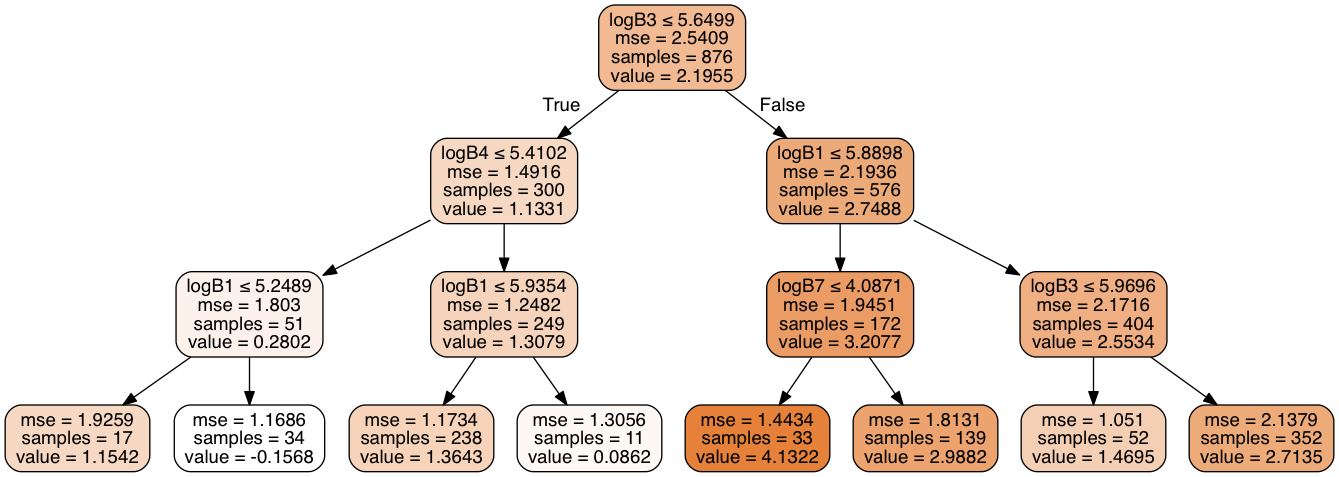

In [79]:
# regression tree
rt = tree.DecisionTreeRegressor(max_depth=3,
 min_samples_split=50, min_samples_leaf=10,
  random_state=0)
rt.fit(X,y)
r2_train = rt.score(X,y)
r2_test = rt.score(X_test,y_test)
mse_test = np.sqrt( np.mean((rt.predict(X_test) - y_test) ** 2) )

print("Root mean squared test error: %.2f %s" %(mse_test,ycol))
print('R2 test score: %.5f' % r2_test)
print('R2 training score: %.5f' % r2_train)

print('Feature importances:')
print(zip(prednames,rt.feature_importances_))

print('Tree:')
dot_data = tree.export_graphviz(rt, out_file=None, 
                         feature_names=prednames,  
                         class_names='logCHLA',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

Image(graph.create_png())  

# use cross validation to figure out how to trim the tree. Look at old notes!

R2 test score: 0.52968
R2 training score: 0.58676
Feature importances:
[('logB1', 0.15336119771722487), ('logB2', 0.0), ('logB3', 0.76369335993962384), ('logB4', 0.0), ('logB5', 0.0), ('logB7', 0.082945442343151321)]
Tree:


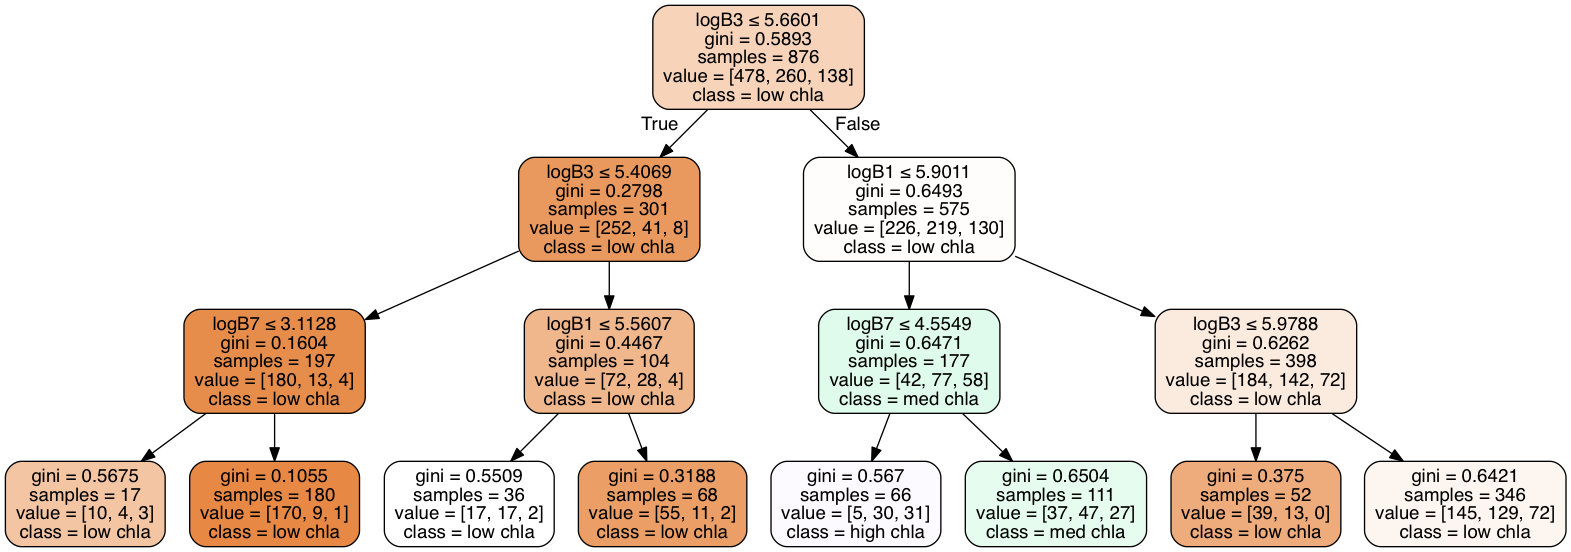

In [37]:
# classification tree
rt = tree.DecisionTreeClassifier(max_depth=3,
 min_samples_split=50, min_samples_leaf=10,
  random_state=0)
rt.fit(X,y)
r2_train = rt.score(X,y)
r2_test = rt.score(X_test,y_test)
# mse_test = np.sqrt( np.mean((rt.predict(X_test) - y_test) ** 2) )

# print("Root mean squared test error: %.2f %s" %(mse_test,ycol))
print('R2 test score: %.5f' % r2_test)
print('R2 training score: %.5f' % r2_train)

print('Feature importances:')
print(zip(prednames,rt.feature_importances_))

print('Tree:')
dot_data = tree.export_graphviz(rt, out_file=None, 
                         feature_names=prednames,  
                         class_names=['low chla','med chla','high chla'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

Image(graph.create_png())  

# use cross validation to figure out how to trim the tree. Look at old notes!
